In [1]:
%%capture
!pip install audiomentations

In [2]:
import torch
import torch.nn.functional as F
import torchaudio
import webrtcvad
import collections
import sys
import numpy as np
import math
import os
import pandas as pd
import random
import IPython.display as ipd
import librosa.display
import librosa
import audiomentations
import matplotlib.pyplot as plt
import torchaudio.transforms as T
from torchaudio.functional import vad
from typing import List, Tuple, Dict, Union
from scipy.signal import butter, sosfilt, sosfilt_zi

# Making sure the experiments are reproducible
seed = 2109
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
def read_audio(
    path: str,
    to_mono: bool = True,
    sample_rate: int = None
) -> Tuple[torch.Tensor, int]:
    """
    Reads a audio file.

    Args:
        path (str): the audio file's path.
        to_mono (bool, optional): convert the signal to mono. Defaults to True.
        sample_rate (int, optional): resample the audio to that specific sample rate
                                     (None if you won't resample). Defaults to None.

    Returns:
        Tuple[torch.Tensor, int]: the audio waveform and the sample rate.
    """
    audio, sr = torchaudio.load(filepath=path)
    
    if sample_rate is not None and sample_rate != sr:
        audio = resample_audio(
            audio=audio,
            sample_rate=sr,
            new_sample_rate=sample_rate
        )
    
    if to_mono and audio.shape[0] > 1:
        audio = stereo_to_mono(audio=audio)
    
    return audio, sr

def create_propor_train_dataframe(
    path: str
) -> pd.DataFrame:
    """
    Creates a PROPOR 2022's pandas DataFrame containing
    all the training files using the same structure as the
    `test_ser_metadata.csv` file.
    
    Args:
        path (str): the path to the CSV file.
    
    Returns:
        df (pd.DataFrame): the pandas DataFrame.
    """
    wav_files = [
        file
        for file in os.listdir(path)
        if file.endswith(".wav")
    ]
    df = pd.DataFrame()
    
    for wav in wav_files:
        wav_file = os.path.basename(wav)
        wav_file = wav_file.split("/")[0]
        label = wav_file.split("_")[-1].replace(".wav", "")
        
        row = pd.DataFrame({
            "file": [os.path.join(path, wav_file)],
            "label": [label],
            "wav_file": [wav_file]
        })
        
        df = pd.concat(
            [df, row],
            axis=0
        )
    
    return df.reset_index(drop=True)

def stereo_to_mono(
    audio: torch.Tensor
) -> torch.Tensor:
    """
    Converts a stereo audio to mono.
    
    Args:
        audio (torch.Tensor): the audio's waveform (stereo).
    
    Returns:
        torch.Tensor: the audio's waveform (mono).
    """
    audio = torch.mean(audio, dim=0, keepdim=True)
    return audio

def create_propor_train_dataframe(
    path: str
) -> pd.DataFrame:
    """
    Creates a PROPOR 2022's pandas DataFrame containing
    all the training files using the same structure as the
    `test_ser_metadata.csv` file.
    
    Args:
        path (str): the path to the CSV file.
    
    Returns:
        df (pd.DataFrame): the pandas DataFrame.
    """
    wav_files = [
        file
        for file in os.listdir(path)
        if file.endswith(".wav")
    ]
    df = pd.DataFrame()
    
    for wav in wav_files:
        wav_file = os.path.basename(wav)
        wav_file = wav_file.split("/")[0]
        label = wav_file.split("_")[-1].replace(".wav", "")
        
        row = pd.DataFrame({
            "file": [os.path.join(path, wav_file)],
            "label": [label],
            "wav_file": [wav_file]
        })
        
        df = pd.concat(
            [df, row],
            axis=0
        )
    
    return df.reset_index(drop=True)

def convert_to_numpy(
    audio: torch.Tensor
) -> np.ndarray:
    return audio.detach().squeeze().numpy().astype(np.float32)

def convert_to_torch(
    audio: np.ndarray
) -> torch.Tensor:
    return torch.from_numpy(audio).unsqueeze(0).to(dtype=torch.float32)

In [4]:
propor_path = "/media/greca/HD/Datasets/PROPOR 2022/data_train/train"
df = create_propor_train_dataframe(propor_path)
df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,non-neutral-male,bpubdl02_segment247_non-neutral-male.wav
1,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bpubmn14_segment89_neutral.wav
2,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bfamdl26_segment93_neutral.wav
3,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bfammn27_segment275_neutral.wav
4,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bfamcv02_segment276_neutral.wav


In [5]:
audios = []
files = df["file"].tolist()
sample_rate = 16000

for file in files:
    audio, sr = read_audio(
        path=file,
        to_mono=True,
        sample_rate=sample_rate
    )
    
    audios.append(audio)

## Applying Low Pass Filter to remove noise (Audiomentation)

In [6]:
audio_test = convert_to_numpy(audios[0])
ipd.Audio(audio_test, rate=sample_rate)

In [7]:
transformer = audiomentations.LowPassFilter(
    min_rolloff=6,
    max_rolloff=6,
    p=1.0
)
audio_lpf = transformer(audio_test, sample_rate=sample_rate)
# audio_lpf = convert_to_numpy(audio_lpf)
ipd.Audio(audio_lpf, rate=sample_rate)

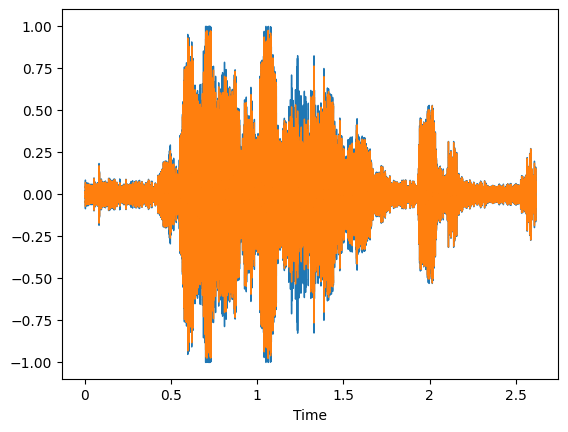

In [8]:
librosa.display.waveshow(audio_test, sr=sample_rate)
librosa.display.waveshow(audio_lpf, sr=sample_rate)

## Applying Low Pass Filter to remove noise (Butterworth Scipy)

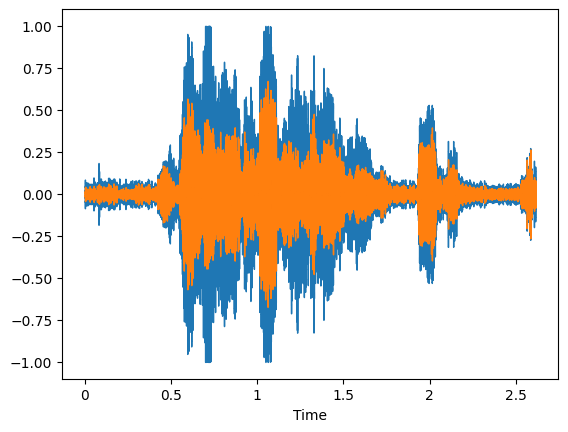

In [9]:
def convert_frequency_to_mel(f: float) -> float:
    """
    Convert f hertz to mels
    https://en.wikipedia.org/wiki/Mel_scale#Formula
    """
    return 2595.0 * math.log10(1.0 + f / 700.0)

def convert_mel_to_frequency(m: Union[float, np.array]) -> Union[float, np.array]:
    """
    Convert m mels to hertz
    https://en.wikipedia.org/wiki/Mel_scale#History_and_other_formulas
    """
    return 700.0 * (10 ** (m / 2595.0) - 1.0)

def butterworth_filter(
    signal: torch.Tensor,
    order: int,
    w: float,
    filter_type: str,
    sample_rate: int,
    analog: bool = False
):
    assert filter_type in ["lowpass", "low", "high", "highpass"]
    assert 0 < w <= sample_rate // 2
    
    signal = convert_to_numpy(signal)
    sos = butter(
        order,
        w,
        filter_type,
        analog=analog,
        output="sos",
        fs=sample_rate
    )
    processed_samples, _ = sosfilt(
        sos, signal, zi=sosfilt_zi(sos) * signal[0]
    )
    processed_samples = processed_samples.astype(np.float32)
    return convert_to_torch(processed_samples)

min_cutoff_freq = 150
max_cutoff_freq = sample_rate // 2

cutoff_mel = np.random.uniform(
    low=convert_frequency_to_mel(min_cutoff_freq),
    high=convert_frequency_to_mel(max_cutoff_freq),
)
w = convert_mel_to_frequency(cutoff_mel)
processed_samples = butterworth_filter(
    audios[0],
    2,
    400,
    "low",
    sample_rate
)

audio_numpy = convert_to_numpy(audios[0])
processed_samples = convert_to_numpy(processed_samples)

librosa.display.waveshow(audio_numpy, sr=sample_rate)
librosa.display.waveshow(processed_samples, sr=sample_rate)
ipd.Audio(processed_samples, rate=sample_rate)

## Applying High Pass Filter to remove noise (Audiomentation)

In [10]:
audio_test = convert_to_numpy(audios[0])
ipd.Audio(audio_test, rate=sample_rate)

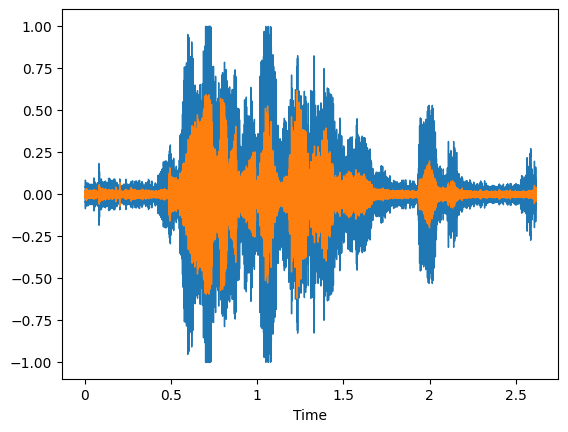

In [11]:
transformer = audiomentations.HighPassFilter(
    min_rolloff=6,
    max_rolloff=6,
    p=1.0
)
audio_lpf = transformer(audio_test, sample_rate=sample_rate)
# audio_lpf = convert_to_numpy(audio_lpf)

librosa.display.waveshow(audio_test, sr=sample_rate)
librosa.display.waveshow(audio_lpf, sr=sample_rate)
ipd.Audio(audio_lpf, rate=sample_rate)

## Applying High Pass Filter to remove noise (Butterworth Scipy)

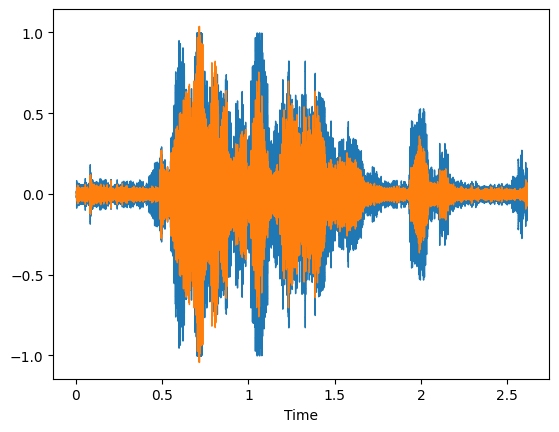

In [12]:
min_cutoff_freq = 20
max_cutoff_freq = 2400

cutoff_mel = np.random.uniform(
    low=convert_frequency_to_mel(min_cutoff_freq),
    high=convert_frequency_to_mel(max_cutoff_freq),
)
w = convert_mel_to_frequency(cutoff_mel)
processed_samples = butterworth_filter(
    audios[0],
    2,
    700,
    "high",
    sample_rate
)

audio_numpy = convert_to_numpy(audios[0])
processed_samples = convert_to_numpy(processed_samples)

librosa.display.waveshow(audio_numpy, sr=sample_rate)
librosa.display.waveshow(processed_samples, sr=sample_rate)
ipd.Audio(processed_samples, rate=sample_rate)

## Applying High Pass and Low Pass Filter to remove noise (Butterworth Scipy)

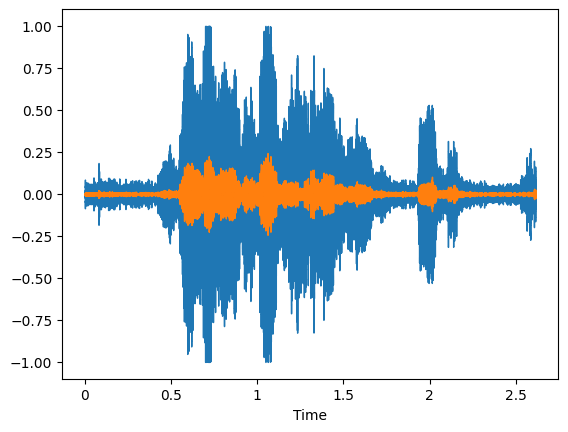

In [13]:
processed_samples = butterworth_filter(
    audios[0],
    2,
    700,
    "high",
    sample_rate
)
processed_samples = butterworth_filter(
    processed_samples,
    2,
    400,
    "low",
    sample_rate
)

audio_numpy = convert_to_numpy(audios[0])
processed_samples = convert_to_numpy(processed_samples)

librosa.display.waveshow(audio_numpy, sr=sample_rate)
librosa.display.waveshow(processed_samples, sr=sample_rate)
ipd.Audio(processed_samples, rate=sample_rate)

In [30]:
class Denoiser:
    def __init__(
        self,
        p: float,
        filters: list,
        sample_rate: int
    ) -> None:
        _valid_filters = ["low_pass", "high_pass"]
        
        assert 0 < p <= 1.0
        assert all([f in _valid_filters for f in filters])
        
        self.p = p
        self.filters = filters
        self.sample_rate = sample_rate
    
    def __call__(
        self,
        waveform: torch.Tensor
    ) -> torch.Tensor:
        rand = torch.rand(1).item()

        if rand < self.p:
            for fil in self.filters:
                if fil == "low_pass":
                    waveform = self._apply_filter(
                        waveform,
                        2,
                        400,
                        "low",
                        self.sample_rate
                    )
                elif fil == "high_pass":
                    waveform = self._apply_filter(
                        waveform,
                        2,
                        700,
                        "high",
                        self.sample_rate
                    )
                    
        return waveform
    
    def _apply_filter(
        self,
        waveform: torch.Tensor,
        order: int,
        w: float,
        filter_type: str,
        sample_rate: int,
        analog: bool = False
    ) -> torch.Tensor:
        assert 0 < w <= sample_rate // 2
        
        signal = convert_to_numpy(waveform)
        sos = butter(
            order,
            w,
            filter_type,
            analog=analog,
            output="sos",
            fs=sample_rate
        )
        processed_samples, _ = sosfilt(
            sos, signal, zi=sosfilt_zi(sos) * signal[0]
        )
        processed_samples = processed_samples.astype(np.float32)
        return convert_to_torch(processed_samples)

denoise = Denoiser(
    p=1,
    filters=["low_pass", "high_pass"],
    sample_rate=16000
)
processed_samples = denoise(audios[0])

# audio_numpy = convert_to_numpy(audios[0])
# processed_samples = convert_to_numpy(processed_samples)

assert torch.all(torch.eq(audios[0], processed_samples))

librosa.display.waveshow(audio_numpy, sr=sample_rate)
librosa.display.waveshow(processed_samples, sr=sample_rate)

AttributeError: 'bool' object has no attribute 'item'

## Applying SpecAugment (Torch)

In [15]:
def extract_melspectrogram(
    audio: torch.Tensor,
    sample_rate: int,
    n_fft: int,
    hop_length: int,
    n_mels: int
) -> torch.Tensor:
    """
    Extracts the mel spectrogram of a given audio.
    
    Args:
        audio (np.ndarray): the audio's waveform.
        sample_rate (int): the audio's sample rate.
        n_fft (int): the number of fft.
        hop_length (int): the hop length.
        n_mels (int): the number of mels.
        f_min (int): the minimum frequency.
        f_max (int): the maximum frequency.
        
    Returns:
        torch.Tensor: the extracted Mel Spectrogram.
    """
    transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=1
    )
    mel_spectrogram = transform(audio)
    return mel_spectrogram

def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

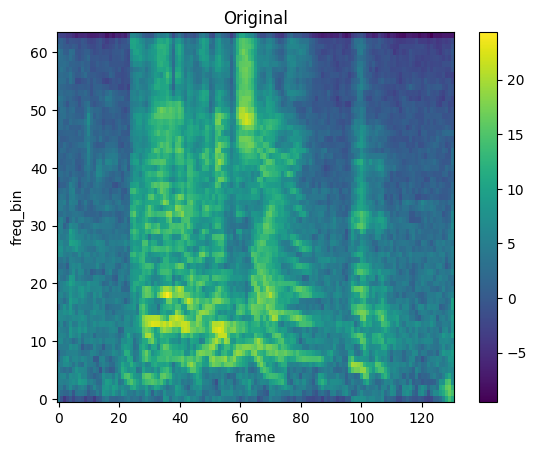

In [16]:
spec = extract_melspectrogram(
    audio=audios[0],
    n_fft=1024,
    hop_length=320,
    n_mels=64,
    sample_rate=16000
)
plot_spectrogram(spec[0], title="Original")

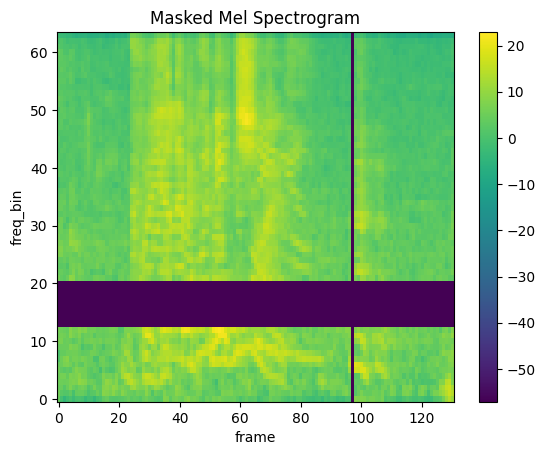

In [17]:
class SpecAugment:
    def __init__(
        self,
        p: float,
        transformations: list,
        mask_samples: int
    ) -> None:
        _valid_transformations = ["time_mask", "frequency_mask"]
        
        assert 0 < p <= 1.0
        assert all([t in _valid_transformations for t in transformations])
        assert mask_samples > 0
        
        self.p = p
        self.transformations = transformations
        self.mask_samples = mask_samples
    
    def __call__(
        self,
        spec: torch.Tensor
    ) -> torch.Tensor:
        rand = torch.rand(1).item()

        if rand < self.p:
            for transformation in self.transformations:
                if transformation == "time_mask":
                    masking = T.TimeMasking(time_mask_param=self.mask_samples)
                elif transformation == "frequency_mask":
                    masking = T.FrequencyMasking(freq_mask_param=self.mask_samples)
                spec = masking(spec)
        
        return spec

spec_augment = SpecAugment(
    p=1,
    transformations=["time_mask", "frequency_mask"],
    mask_samples=10
)
masked_spec = spec_augment(spec)
plot_spectrogram(masked_spec[0], title="Masked Mel Spectrogram")

## Mixup Data Augmentation

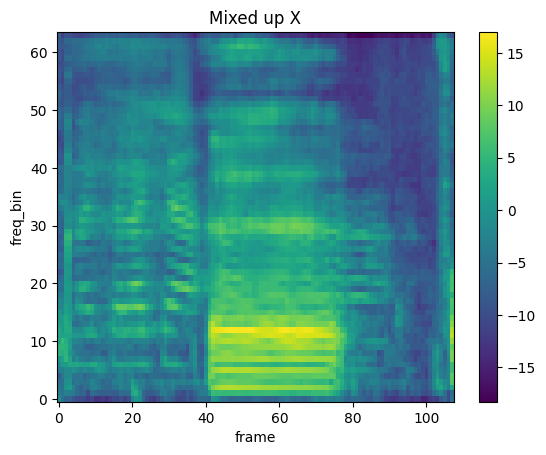

In [18]:
class Mixup:
    def __init__(
        self,
        alpha: float = 1.0
    ) -> None:
        self.alpha = alpha
        self.lam = 0.0
    
    def __call__(
        self,
        x: torch.Tensor,
        y: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.alpha > 0:
            self.lam = np.random.beta(self.alpha, self.alpha, 1)[0]
        else:
            self.lam = 1
        
        batch_size = x.size()[0]
        index = torch.randperm(batch_size)

        mixed_x = self.lam * x + (1 - self.lam) * x[index, :]
        mixed_y = self.lam * y + (1 - self.lam) * y[index]
        return mixed_x, mixed_y

spec1 = extract_melspectrogram(
    audio=audios[1],
    n_fft=1024,
    hop_length=320,
    n_mels=64,
    sample_rate=16000
)

spec2 = extract_melspectrogram(
    audio=audios[2],
    n_fft=1024,
    hop_length=320,
    n_mels=64,
    sample_rate=16000
)

x = torch.concat((spec1[:, :, :108], spec2[:, :, :108]))
y = torch.Tensor([[0, 0, 1], [0, 1, 0]])

mixup = Mixup()
mixed_x, mixed_y = mixup(x, y)
plot_spectrogram(mixed_x[0], title="Mixed up X")